<a href="https://colab.research.google.com/github/alheir/nnii-cv/blob/main/tp02_datacentric_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 - Datacentric CV

25.87 - Redes Neuronales II

> Computer Vision


Alumno: HEIR, Alejandro Nahuel

Legajo: 62496

e-mail: aheir@itba.edu.ar

Utilizando la siguiente librería [ImageNet Datasets Downloader](https://github.com/mf1024/ImageNet-Datasets-Downloader)

1. Bajar imágenes de 20 clases.
2. Instanciar una ResNet-18
    * Loss = "categorical_crossentropy"
    * Optimizer = "adam"
    * Early Stopping
    * ReduceLearningRateOnPlateau
    * ModelCheckPoint
3. Entrenar el modelo optimizando los HP anteriores.
4. A partir de ahora, sin modificar los parámetros anteriores, reentrenar el modelo utilizando distintas técnicas de aumentación (desde el mismo punto, preentrenado con imagenet).
    * Utilizar siempre el mismo conjunto de datos para validación (estos no se aumentan)
5. Para la mejor performance que hayan obtenido, informar el pipeline de aumentación que utilizaron.

*Bonus: hacer búsqueda de hiperparámetros automática con MLFlow y Tensorboard.*

# Paquetes y módulos

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import requests

import os
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import albumentations as A

In [2]:
!pip install -U albumentations --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 17.3 MB/s eta 0:00:00


# ImageNet Datasets Downloader

## Descarga del dataset

In [4]:
!git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git

Cloning into 'ImageNet-Datasets-Downloader'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 130 (delta 5), reused 6 (delta 2), pack-reused 113 (from 1)
Receiving objects: 100% (130/130), 1.58 MiB | 3.58 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [5]:
!rm -rf data/imagenet_images/

In [8]:
n_classes = 20
n_images_per_class = 100

In [9]:
!mkdir -p data
!python ImageNet-Datasets-Downloader/downloader.py \
    -data_root data \
    -number_of_classes {n_classes} \
    -images_per_class {n_images_per_class} \
    # -multiprocessing_workers 1

Picked the following clases:
['bass', 'sled dog', 'middleweight', 'light heavyweight', 'Spanish dagger', 'popover', 'active citizen', 'loofah', 'fan belt', 'whisk', 'telpherage', 'successor', 'carpenteria', 'cat', 'hook', 'marimba', 'jockey', 'coat closet', 'life', 'hunk']
Scraping images for class "bass"
Multiprocessing workers: 8
Scraping images for class "sled dog"
Multiprocessing workers: 8

Scraping stats:
STATS For class is_flickr:
 tried 242.0 urls with 170.0 successes
70.24793388429752% success rate for is_flickr urls 
0.06642465030445772 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 242.0 urls with 170.0 successes
70.24793388429752% success rate for all urls 
0.06642504299388212 seconds spent per all succesful image download
Scraping images for class "middleweight"
Multiprocessing workers: 8
Scraping images for class "light heavyweight"
Multiprocessing workers: 8

Scraping stats:


In [10]:
images_root_path = "data/imagenet_images/"

In [11]:
!ls {images_root_path}

'active citizen'  'coat closet'   jockey	       marimba	     'Spanish dagger'
 bass		  'fan belt'	  life		       middleweight   successor
 carpenteria	   hook		 'light heavyweight'   popover	      telpherage
 cat		   hunk		  loofah	      'sled dog'      whisk


In [12]:
folder_list = os.listdir(images_root_path)
folder_list.sort()
print(folder_list)

['Spanish dagger', 'active citizen', 'bass', 'carpenteria', 'cat', 'coat closet', 'fan belt', 'hook', 'hunk', 'jockey', 'life', 'light heavyweight', 'loofah', 'marimba', 'middleweight', 'popover', 'sled dog', 'successor', 'telpherage', 'whisk']


## Carga del dataset

In [13]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [15]:
train_ds = image_dataset_from_directory(
    images_root_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    images_root_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical'
)

# Preprocessing the dataset using ResNet's preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

Found 2082 files belonging to 20 classes.
Using 1666 files for training.
Found 2082 files belonging to 20 classes.
Using 416 files for validation.


In [16]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

Train dataset size: 53
Validation dataset size: 13


## Split del dataset (train test val)

# ResNet50

## Instancia

In [17]:
# Instanciar la ResNet50 sin preentrenamiento
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Agregar capas superiores personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Capa adicional
predictions = Dense(n_classes, activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,706,388 (98.06 MB)

 Trainable params: 25,653,268 (97.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 1er entrenamiento

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 112s 933ms/step - accuracy: 0.0656 - loss: 5.1389 - val_accuracy: 0.0529 - val_loss: 857.5828 - learning_rate: 0.0010
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - accuracy: 0.1152 - loss: 2.9862 - val_accuracy: 0.1226 - val_loss: 2.8982 - learning_rate: 0.0010
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 408ms/step - accuracy: 0.1768 - loss: 2.6599 - val_accuracy: 0.1755 - val_loss: 2.5163 - learning_rate: 0.0010
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 358ms/step - accuracy: 0.2550 - loss: 2.4392 - val_accuracy: 0.1827 - val_loss: 2.5907 - learning_rate: 0.0010
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - accuracy: 0.2029 - loss: 2.5095 - val_accuracy: 0.1587 - val_loss: 2.6569 - learning_rate: 0.0010
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 465ms/step - accuracy: 0.2707 - loss: 2.3779 - val_accuracy: 0.2260 - val_loss: 2.4245 - learning_rate: 0.0010
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 400ms/step - accuracy: 0.2907 - loss:

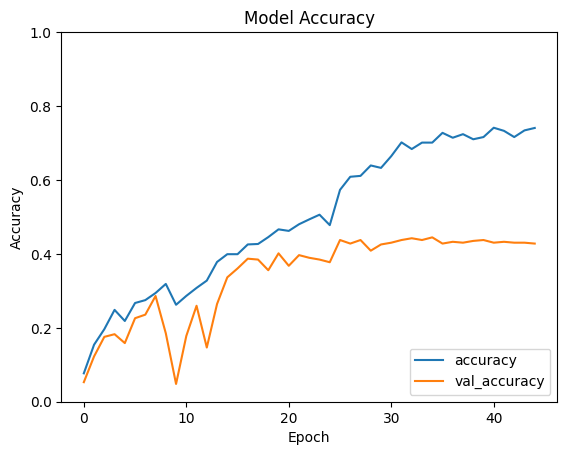

In [18]:
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('prebest_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Definición de los hiperparámetros para el entrenamiento
EPOCHS = 50

# Entrenar el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Mostrar la historia de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

## Augmentation

In [23]:
# 1. Cargar los pesos del mejor modelo
model.load_weights('prebest_model.keras')

In [19]:
augmentation_pipelines = {
    "pipeline_1": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussNoise(var_limit=(10, 50), p=0.3),  # Añadir ruido gaussiano
    ]),
    "pipeline_2": A.Compose([
        A.VerticalFlip(p=0.5),
        A.GaussNoise(var_limit=(10, 30), p=0.4),
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(blur_limit=3, p=0.3),  # Aplicar desenfoque
    ]),
    "pipeline_3": A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=0.5),
        A.RandomCrop(height=200, width=200, p=1),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),  # Jitter de color
    ]),
    # "pipeline_4": A.Compose([
    #     A.RandomGamma(p=0.2),
    #     A.Resize(height=224, width=224, p=1),  # Redimensionar la imagen
    #     A.HorizontalFlip(p=0.5),
    #     A.CoarseDropout(num_holes=8, max_h_size=8, max_w_size=8, p=0.3),  # Aplicar CoarseDropout
    # ]),
    "pipeline_5": A.Compose([
        A.RandomCrop(height=200, width=200, p=0.5),
        A.Resize(height=224, width=224, p=1),  # Redimensionar después de recortar
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.3),  # Ruido multiplicativo
        A.ElasticTransform(alpha=1.0, sigma=50, p=0.2),  # Transformación elástica
    ])#,
    # "pipeline_6": A.Compose([
    #     A.RandomSizedBBoxSafeCrop(height=200, width=200, erosion_rate=0.2, p=0.5),
    #     A.HorizontalFlip(p=0.5),
    #     A.RandomBrightnessContrast(p=0.2),
    #     A.ImageCompression(quality_lower=70, quality_upper=90, p=0.3),  # Compresión de imagen
    # ]),
}

In [20]:
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('augbest_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [24]:
# Definir un generador de datos que aplica aumentación
def augmented_data_generator(dataset, augmentations, batch_size, steps_per_epoch):
    while True:
        for images, labels in dataset.take(steps_per_epoch):
            # Verificar si las imágenes tienen tamaño válido
            if images.shape[0] == 0:
                continue  # Saltar si no hay imágenes

            augmented_images = []
            for img in images.numpy():
                augmented = augmentations(image=img)
                augmented_images.append(augmented['image'])

            yield np.array(augmented_images), labels.numpy()

def train_with_augmentation(augmentation, model, train_ds, val_ds):
    # Asegurarse de que el generador de datos esté bien configurado
    steps_per_epoch = len(train_ds)# // BATCH_SIZE
    validation_steps = len(val_ds)# // BATCH_SIZE

     # Repetir el dataset para evitar quedarse sin datos
    train_ds = train_ds.repeat()  # Repetir el dataset
    val_ds = val_ds.repeat()      # Repetir el dataset también para la validación

    # Entrenamiento del modelo
    history = model.fit(
        augmented_data_generator(train_ds, augmentation, BATCH_SIZE, steps_per_epoch),
        validation_data=val_ds,
        epochs=50,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    return history

In [25]:
# Variable para guardar los mejores resultados
best_score = 0
best_pipeline = None

# Reiniciar el modelo antes de cada reentrenamiento
for name, pipeline in augmentation_pipelines.items():
    print(f"Entrenando con {name}...")

    # Reiniciar el modelo
    model.load_weights('prebest_model.keras')  # Cargar pesos del primer entrenamiento

    # Entrenar con el pipeline actual
    history = train_with_augmentation(pipeline, model, train_ds, val_ds)

    # Evaluar el score
    val_accuracy = max(history.history['val_accuracy'])  # Mejor precisión de validación
    print(f"Mejor precisión de validación con {name}: {val_accuracy}")

    # Comparar y almacenar el mejor score
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_pipeline = name

# Informar el mejor pipeline
print(f"\nEl mejor pipeline es '{best_pipeline}' con una precisión de validación de {best_score:.4f}.")

Entrenando con pipeline_1...
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 566ms/step - accuracy: 0.2313 - loss: 3.5312 - val_accuracy: 0.4159 - val_loss: 2.2561 - learning_rate: 8.0000e-06
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 353ms/step - accuracy: 0.2816 - loss: 2.5279 - val_accuracy: 0.4135 - val_loss: 2.2563 - learning_rate: 8.0000e-06
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.3235 - loss: 2.2790 - val_accuracy: 0.4207 - val_loss: 2.1611 - learning_rate: 8.0000e-06
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.3033 - loss: 2.2755 - val_accuracy: 0.4207 - val_loss: 2.1401 - learning_rate: 8.0000e-06
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 478ms/step - accuracy: 0.3188 - loss: 2.2290 - val_accuracy: 0.4303 - val_loss: 2.0931 - learning_rate: 8.0000e-06
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - accuracy: 0.3332 - loss: 2.1307 - val_accuracy: 0.4159 - val_loss: 2.1054 - learning_rate: 8.0000e-06
Epoch 7/50
53/53 ━━━━━━━━━━━━

ValueError: RandomSizedBBoxSafeCrop requires ['bboxes'] missing keys: {'bboxes'}